In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps

# Load dataset
df = pd.read_csv('adult_with_headers.csv')
print(df.columns.tolist())
df.columns = df.columns.str.strip().str.lower().str.replace('-', '_').str.replace(' ', '_')
print(df.columns.tolist())


['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


In [7]:
# 1. Data Exploration and Preprocessing
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                 age workclass        fnlwgt education  education_num  \
count   32561.0

In [9]:
# Replace missing values marked as '?' with NaN
df.replace('?', np.nan, inplace=True)

In [11]:
# Handle missing values
df.dropna(inplace=True)

In [13]:
# Identify numerical and categorical features
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical = df.select_dtypes(include=['object']).columns.tolist()

In [15]:
# Scaling - Standard and MinMax
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

df_std_scaled = df.copy()
df_std_scaled[numerical] = scaler_std.fit_transform(df[numerical])

df_minmax_scaled = df.copy()
df_minmax_scaled[numerical] = scaler_minmax.fit_transform(df[numerical])


In [33]:
# 2. Encoding Techniques
df_encoded = df.copy()
df_encoded.columns = df_encoded.columns.str.strip().str.lower().str.replace('-', '_').str.replace(' ', '_')
for col in categorical:
    if df_encoded[col].nunique() < 5:
        df_encoded = pd.get_dummies(df_encoded, columns=[col])
    else:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

In [39]:
df_encoded['capital_gain_log'] = np.log1p(df_encoded['capital_gain'])

In [41]:
df_encoded['capital_loss_log'] = np.log1p(df_encoded['capital_loss'])
df_encoded['working_hours_group'] = pd.cut(
    df_encoded['hours_per_week'],
    bins=[0, 20, 40, 60, 100],
    labels=['Low', 'Medium', 'High', 'Very High']
)

In [49]:
# Transform skewed numerical feature
df_encoded['capital_loss_log'] = np.log1p(df_encoded['capital_loss'])

In [51]:
# Outlier detection and removal using Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(df_encoded[numerical])
df_encoded['outlier'] = outliers
df_no_outliers = df_encoded[df_encoded['outlier'] == 1].drop(columns='outlier')

In [53]:
# PPS analysis
pps_matrix = pps.matrix(df_no_outliers)
pps_filtered = pps_matrix[pps_matrix['ppscore'] > 0.1]


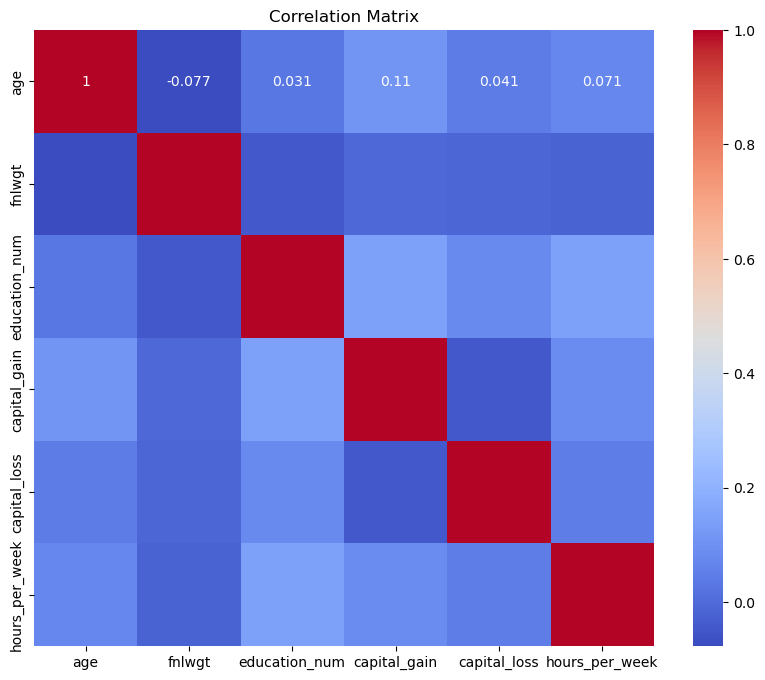

In [55]:
# Correlation matrix for comparison
corr = df_no_outliers[numerical].corr()

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

pps_matrix = pps.matrix(df_no_outliers)
pps_filtered = pps_matrix[pps_matrix['ppscore'] > 0.1]

In [57]:
 #Show top relationships
print(pps_filtered[['x', 'y', 'ppscore']].sort_values(by='ppscore', ascending=False).head())


                  x                    y  ppscore
0               age                  age      1.0
293       sex_ Male          sex_ Female      1.0
210    capital_loss         capital_loss      1.0
231  hours_per_week       hours_per_week      1.0
239  hours_per_week  working_hours_group      1.0
